In [81]:
from skimage import io
from skimage import color

In [82]:
from skinbot.dataset import * 
from skinbot.config import read_config, Config
from skinbot.utils import *
from skinbot.models import get_model
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [83]:
root = './data'
labels = read_labels_xls(root, concat=True)


In [84]:
config = read_config()
C = Config()
C.set_config(config)

In [85]:
# all_dataloader = get_dataloaders(config, batch=16, mode='all')


In [86]:
all_dataloader = get_dataloaders(config, batch=16, mode='test', target='segmentation', fold_iteration=0)


inputsize  <class 'tuple'>
Fold label used as testing set is: 4
Number of indices test : 131
Number of indices training: 525
removing aux_files
Removing detection without boxes...
finding ... 0/130
finding ... 50/130
finding ... 100/130
Remove file CONTACT_DERMATITIS_6_TP5_IMAGIC_2011270620200.JPG because it doesn't have boxes
Remove file BLAND_56_IMAGIC_1801240358821.JPG because it doesn't have boxes
Remove file Malignant_2_IMAGIC_1704240282633.JPG because it doesn't have boxes
Remove file INFECTION_13_IMAGIC_1501220081256.JPG because it doesn't have boxes
Remove file Malignant_137_4483743_11772893_S_Nr_001_003.JPG because it doesn't have boxes
Remove file CONTACT_DERMATITIS_11_IMAGIC_1906050498235.JPG because it doesn't have boxes
Remove file PYODERMA_GANGRAENOSUM_5_IMAGIC_1505060100334.JPG because it doesn't have boxes
Remove file Malignant_48_IMAGIC_1905160492501.JPG because it doesn't have boxes
Remove file BLAND_28_TP1_IMAGIC_2111030676480.JPG because it doesn't have boxes
Remove

In [87]:
for x,y in all_dataloader:
#     print('x: ', x)
    print('y: ', y)
    break

y:  tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])


In [88]:
target_colors = {
        'background':  np.array([128,128,128]),
        'bland': np.array([150,120,40]),
        'granulation': np.array([11,4,200]),
        'fibrin': np.array([200,140,1]),
        'scar': np.array([242,126,53]),
        'hyperpigm.': np.array([180,180,1]),
        'xerosis': np.array([1,180,190]),
        'erythema': np.array([49,49,111]),
        'macerated': np.array([111,24,1]),
        'necrosis': np.array([245,0,0,]),
        'hematoma': np.array([1,122,0]),
        'vessel': np.array([59,131,189]),
        'poikolderm': np.array([124,0,200]),
        'hypertrophic': np.array([200,200,60]),
        'scale': np.array([3,220,22])
    }
colors = np.stack(list(target_colors.values()), axis=0)



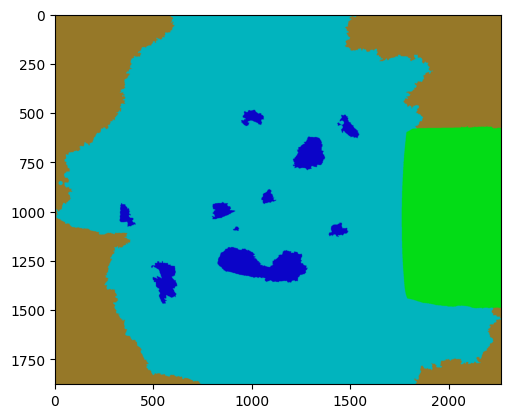

In [89]:
xx = x.squeeze().numpy()
yy = y.squeeze().numpy()
# print(colors[y])
# # Generate automatic colouring from classification labels
plt.imshow(colors[y].squeeze())
plt.show()

# show images

In [90]:
log_interval = 1
log_interval = 1
config = read_config()
root_dir = config["DATASET"]["root"]
best_or_last = 'best'
only_eval = True
fold = 0
model_name = 'unet'
fuzzy_labels = False
EPOCHS = 100
LR = 0.00001
display_info = True
# gpu device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = all_dataloader.dataset

In [91]:

def plot_sample(idx, model_path):
    print('loading models')
    model, optimizer = get_model(model_name, optimizer='SGD', lr=LR)
#     model.load_state_dict(torch.load(model_path))
    model = load_models(model, model_path, device)
    model.eval()
    print('done')
    # selects sample
    sample_19 = dataset[idx]
    x,y = sample_19
    x = torch.unsqueeze(x,0)
    # makes prediciont
    with torch.no_grad():
        pred_19 = model(x)
        # pred_19 = torch.sigmoid(pred_19)
        #TODO: fix here!!!
        pred_mask = process_prediction(pred_19)
    # plot bars and image
#     target_num_to_str = {v:k for k,v in C.labels.target_str_to_num.items()}
#     print(target_num_to_str)
#     fname_19 = os.path.join(dataset.images_dir, dataset.image_fnames[idx])
#     if not dataset.crop_lesion: # crop in target:
#         image_19 = read_image(fname_19).numpy().transpose(1,2,0)
#     else:
#         image_19 = read_image(fname_19).numpy()
#         cc = dataset._crop_boxes[dataset.image_fnames[idx]]
#         image_19 = crop_lesion(image_19, cc).transpose(1,2,0)
    image_19 = (x-x.min())/(x.max()-x.min())
    image_19 = image_19[0].numpy().transpose(1,2,0)
    fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(15,15))
    
    ax[0].imshow(image_19)
    ax[0].imshow(pred_mask, alpha=0.3)
    ax[0].set_title(dataset.image_fnames[idx])
    
    ax[1].imshow(image_19)
    ax[1].imshow(colors[y].squeeze(), alpha=0.3)
    ax[1].set_title('GT')
    
    ax[2].imshow(image_19)
    ax[2].set_title('ORG')

    plt.show()
    

In [92]:
def process_prediction(pred):
    """
    get_prediction

    """
    target_num_str = {v:k for k,v in C.labels.target_str_to_num.items()}
    pred_mask = torch.argmax(pred, dim=1).squeeze()
    return colors[pred_mask].squeeze()


In [93]:
def detect_object(img, pred_boxes, pred_class, ax, rect_th=4, text_size=3, text_th=4):
    """
    object_detection
    """
    boxes, pred_cls = pred_boxes, pred_class
    # print(len(boxes))
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 200), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])


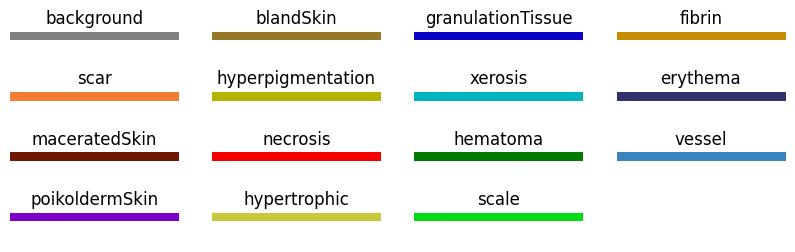

In [94]:
fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(10,3))
square_x = np.ones((5,100))
target_num_str = {v:k for k,v in C.labels.target_str_to_num.items()}
for ii in range(4):
    for jj in range(4):
        ax = axs[ii][jj]
        i = ii*4+jj
        if i>14:
            ax.axis('off')
            continue
        color = colors[i]
        square = np.stack([square_x*c for c in color], axis=-1)
        ax.imshow(square/255.0)
        ax.set_title(target_num_str[i])
        ax.axis('off')
    


loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


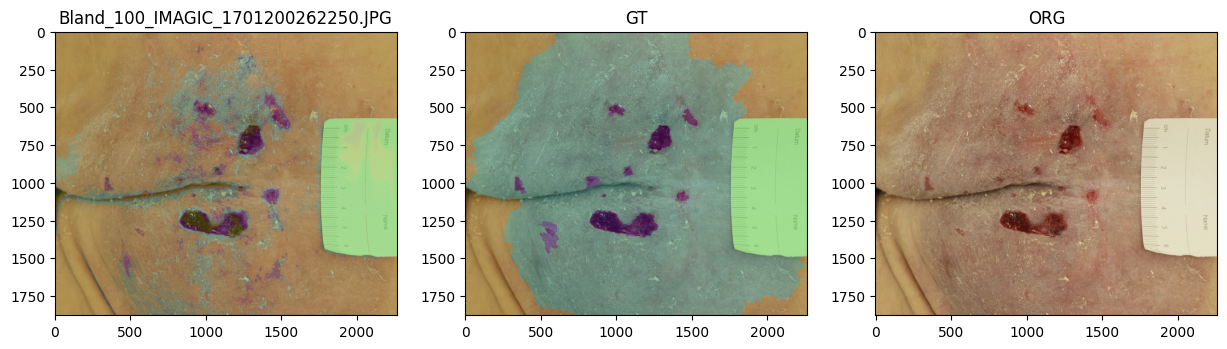

loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


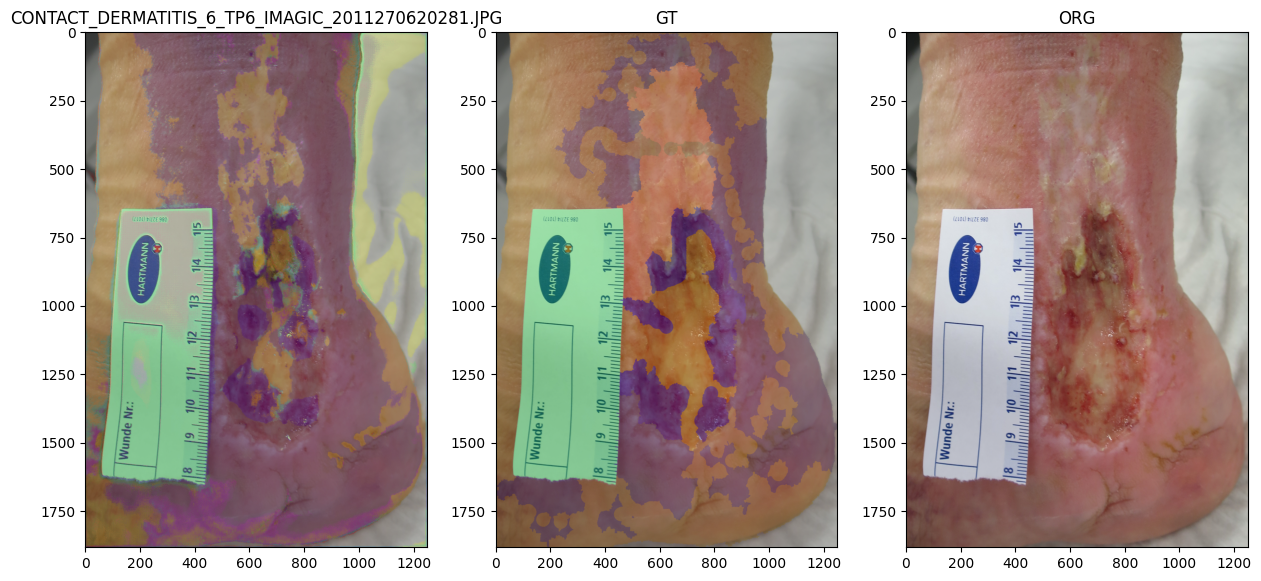

loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


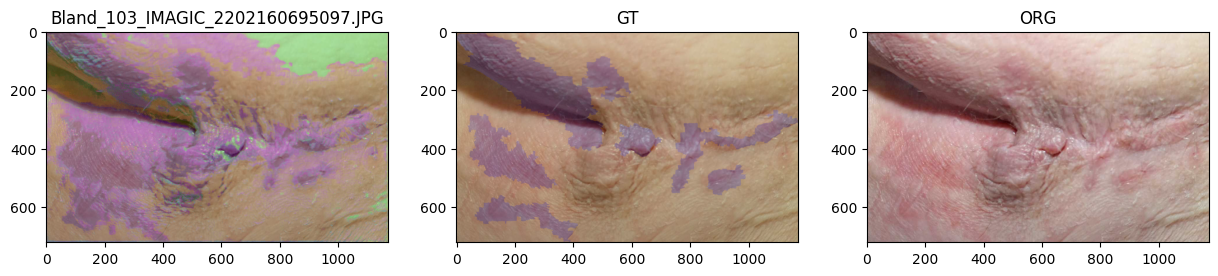

loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


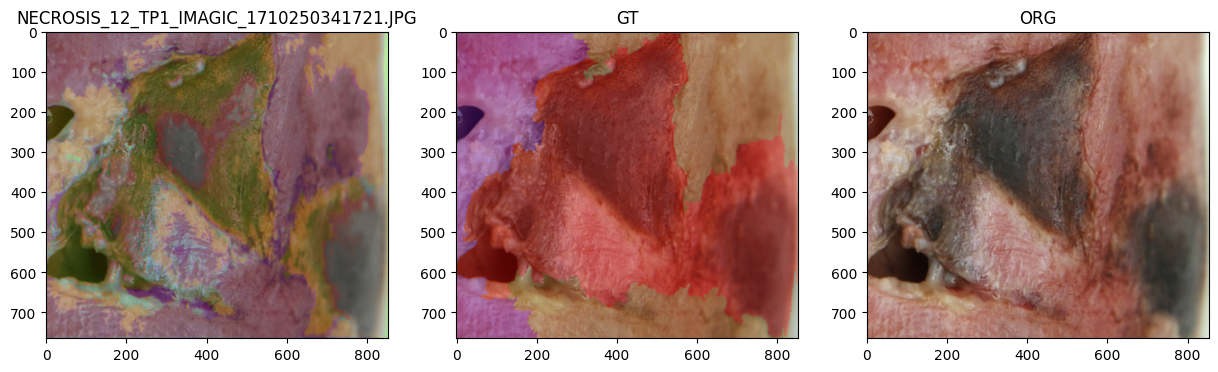

loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


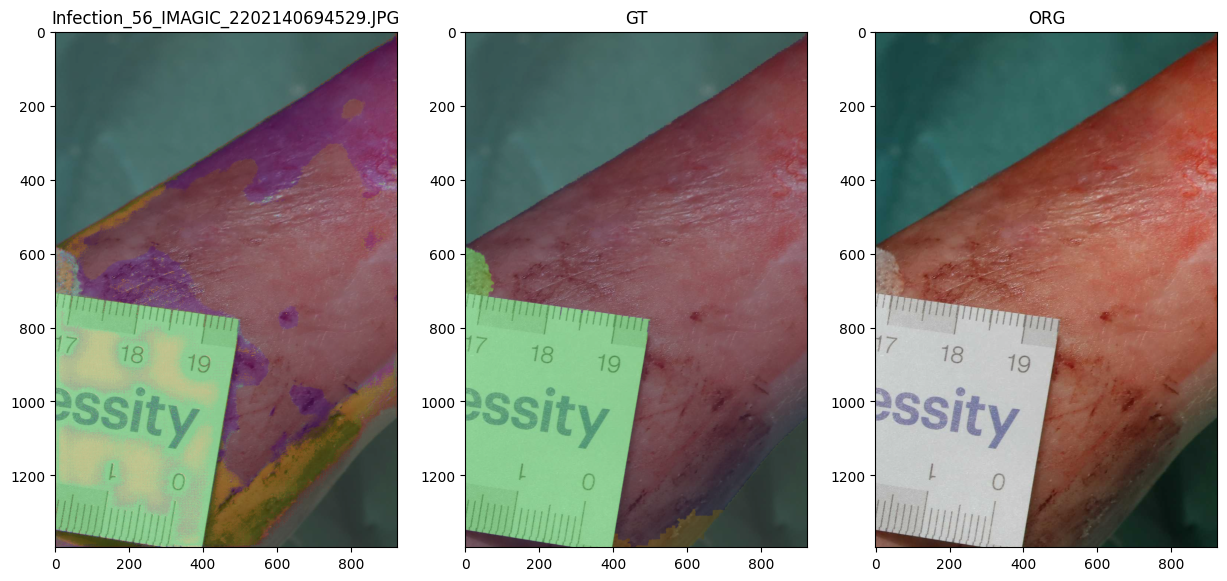

loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


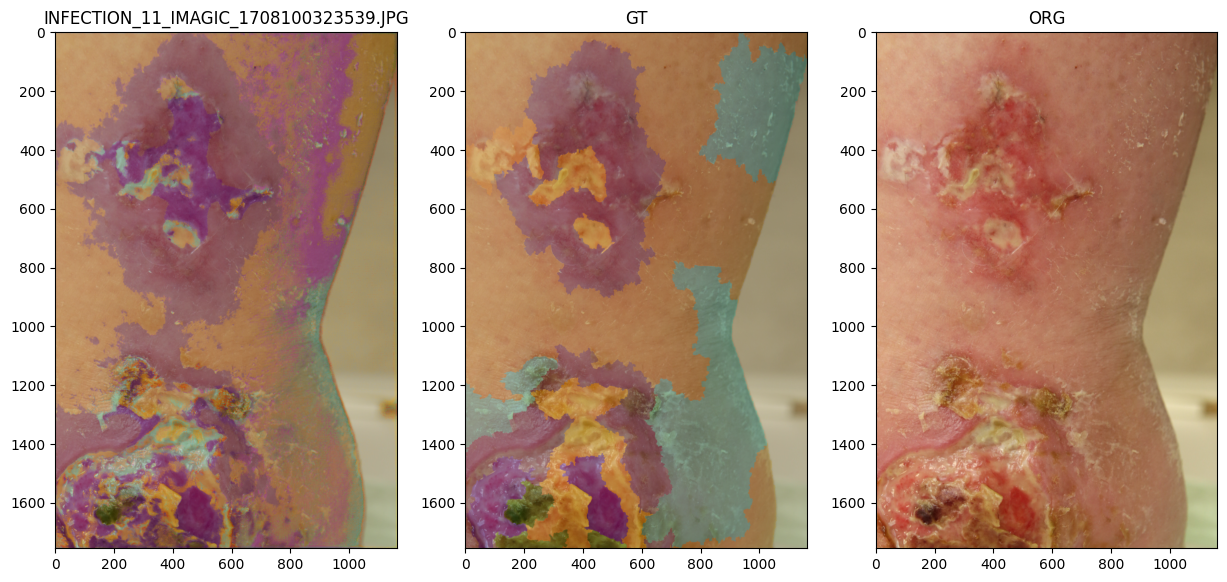

loading models
success loading model /media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt into cpu
done


In [ ]:
model_path = "/media/doom/GG2/skin-project/unet_models/fold0/best_models/best_fold=0_unet_segmentation_segmentation_model_ValDice=0.2142.pt"
for i in range(len(dataset)):
    plot_sample(i, model_path)
    
    